Command for bootstrap runs:
`python train.py mode=send_job_bootstrap model=pulse data=jsfs_UNIF_Yoruba_French_Papuan_Vindija_Denisovan_3419145_108.npy niter=500 bound_sampler=True train_pars=eta,pi transformed=False proc=GPU file_name=bs.pickle q=0.999 lr_pi=0.001 lr_eta=0.5 nSNPs=1000000 njobs=100`

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%alias_magic t timeit
%load_ext memory_profiler

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [2]:
# import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1."
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
# import jax
# jax.config.update('jax_platform_name', 'cpu')
# jax.devices()

In [3]:
import jax
import optax
import sys

import demes, demesdraw, sparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from momi3.Params import Params
from momi3.MOMI import Momi
from momi3.optimizers import optax_for_momi
from momi3.utils import bootstrap_sample

import re
import math
import pickle
import tskit

from tqdm.notebook import tqdm, trange

from scipy import stats, optimize
import numpy as np
import jax.numpy as jnp
import seaborn as sns

from ast import literal_eval

from train import get_demo, get_params, get_lr_vector

/mnt/turbo/eneswork/jthlab/momi3/src/momi3/utils.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
sys.path.append("../")
from Timing_util import *

In [5]:
dissertation_dir = '../../PhD-Dissertation/'

In [6]:
jsfs = np.load('jsfs_UNIF_Yoruba_French_Papuan_Vindija_Denisovan_3419145_108.npy')

In [7]:
print(f'# Number of SNPs: {jsfs.sum()/1e6:.1f} Millions')

# Number of SNPs: 29.9 Millions


In [8]:
print(f'# Non-zero SFS entries: {(jsfs != 0).sum()}')

# Non-zero SFS entries: 453047


In [9]:
nnz = (jsfs != 0).sum()

In [10]:
nnz / 6

75507.83333333333

In [11]:
sampled_demes = ('Yoruba', 'French', 'Papuan', 'Vindija', 'Denisovan')
sample_sizes = [i - 1 for i in jsfs.shape]

In [12]:
demo = get_demo('pulse')

In [13]:
momi = Momi(demo, sampled_demes, sample_sizes, jitted=True, batch_size=75600, low_memory=True)

In [14]:
params = Params(momi)
params.set_train_all_etas(True)
params.set_train_all_pis(True)
params.set_train('eta_0', False) # Ancestral pop size is not inferred
print(f"ancestral size: {params['eta_0']}")

ancestral size: 7310.0


In [15]:
# bounds = momi.bound_sampler(params, 10000, min_lineages=2, quantile=0.999)
# momi = momi.bound(bounds)

In [16]:
#momi.loglik(params, jsfs)

In [17]:
ttds = []

for i in range(100):
    try:
        with open(f'jsfs_UNIF_Yoruba_French_Papuan_Vindija_Denisovan_3419145_108/bs{i}.pickle', 'rb') as f:
            ret = pickle.load(f)
        history = ret['history']
        ind = np.argmin(history['LLs'])
        ttd = history['ttds'][ind]
        ttd = {i: float(ttd[i]) for i in ttd}
        ttds.append(ttd)
    except:
        pass
        print('x')
    
df = pd.DataFrame(ttds)

In [22]:
theta_mu = df.mean().to_dict()
theta_sigma = df.std().to_dict()

In [23]:
params.set_optimization_results(theta_mu)

In [24]:
#momi.loglik(params, jsfs, theta_train_dict=ttd)

In [25]:
SNR = {i: theta_mu[i] / theta_sigma[i] for i in theta_mu} # Signal to noise ratio

In [26]:
params.set_train('eta_12', False)
params.set_train('eta_10', False)

from matplotlib.pyplot import cm

color_list = list(cm.tab10.colors)
color_pastel = list(cm.Pastel1.colors)

positions={
    'ancestral': 0,
    'AMH': 37500,
    'OOA': 15000,
    'Yoruba': 60000,
    'French': 30000,
    'Papuan': 0,
    'NeaDenAnc': -50000,
    'NeanderthalGHOST': -30000,
    'Vindija': -40000,
    'DenisovanGHOST': -70000,
    'Denisovan': -55000
}

colors = {
    'ancestral': color_list[0],
    'AMH': color_list[1],
    'OOA': color_list[2],
    'Yoruba': color_list[3],
    'French': color_list[4],
    'Papuan': color_list[5],
    'NeaDenAnc': color_pastel[1],
    'NeanderthalGHOST': color_pastel[0],
    'Vindija': color_pastel[1],
    'DenisovanGHOST': color_pastel[2],
    'Denisovan': color_pastel[3]
}

In [27]:
# from momi3.utils import halfsigmoid
# f = lambda x: halfsigmoid(1/x, 0.03)

# import matplotlib as mpl
# from matplotlib.colors import LinearSegmentedColormap
# import matplotlib.colors as mcolors
# from matplotlib.colors import ListedColormap

# vals = list(SNR.values())
# colors_SNR = [(1.0, 1.0, 1.0), (1.0, 0, 0)]
# cm = mcolors.LinearSegmentedColormap.from_list("Custom", colors_SNR)
# box_color = cm(f(np.linspace(min(vals), max(vals), 100)))
# my_cmap = ListedColormap(box_color)

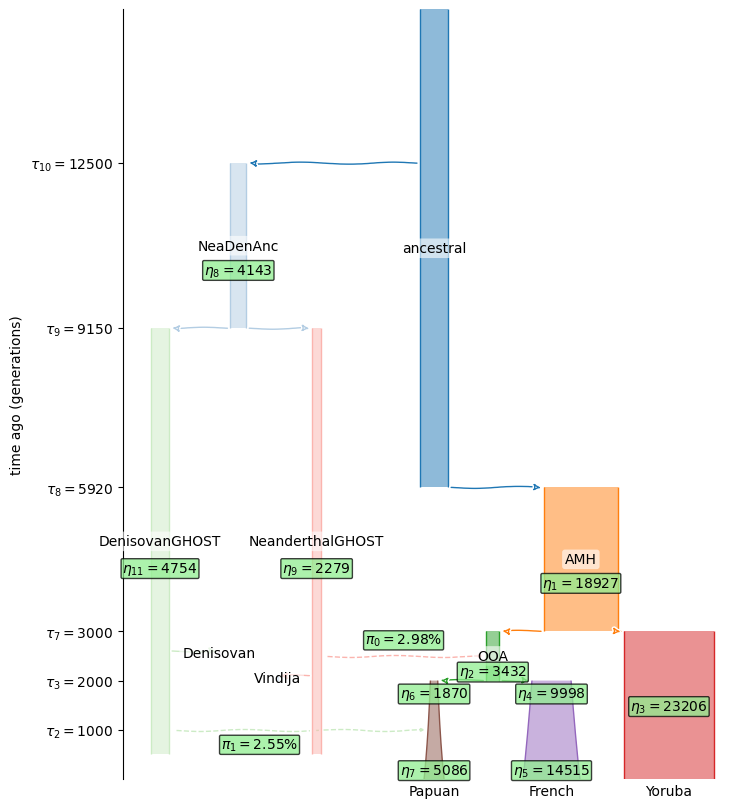

In [24]:
figure_name = 'OOA_hominid_5'
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
params.tubes(
    True, True,
    log_time=False,
    hide_non_inferreds=True,
#     USER_DICT=SNR,
#     color_intensity_function=f,
    tau_keys=['tau_2', 'tau_3', 'tau_7', 'tau_8', 'tau_9', 'tau_10'],
    fontsize=10,
    ax=ax,
    positions=positions,
    colours=colors,
    nudge_text_pos={
        'pi_1': {'x': -10000, 'y':-470},
        'pi_0': {'y': 150},
        'eta_9': {'y': 3600},
        'eta_11': {'y': 3600},
        'eta_6': {'y': -100},
        'eta_4': {'y': -100},
        'eta_1': {'y': 800},
        'eta_8': {'y': 1000},
        'eta_3': {'y': 1300}
    })

# c = plt.pcolor(np.zeros((1, 1)),linewidths=0, cmap=my_cmap, vmin=min(vals), vmax=max(vals))
# clb = plt.colorbar(c)
# clb.ax.set_title('SNR')


plt.savefig(f"{dissertation_dir}figures/chapter3/demo/{figure_name}.pdf", format="pdf", bbox_inches="tight", dpi=600)


In [25]:
demes.dump(params.demo_graph, filename='arc5_pulse_inferred.yaml', format='yaml', simplified=False)

In [26]:
growth_rate = lambda Ne0, Ne1, tau: jnp.log(Ne0 / Ne1) / tau

In [27]:
eta_5 = jnp.array(df['eta_5'])
eta_4 = jnp.array(df['eta_4'])
tau_3 = params['tau_3'].num
df['gr_FR'] = 100 * growth_rate(eta_5, eta_4, tau_3)

eta_7 = jnp.array(df['eta_7'])
eta_6 = jnp.array(df['eta_6'])
tau_3 = params['tau_3'].num
df['gr_PA'] = 100 * growth_rate(eta_7, eta_6, tau_3)

In [28]:
df['pi_0'] = 100 * df['pi_0']
df['pi_1'] = 100 * df['pi_1']

In [29]:
etas = [f'eta_{i}' for i in list(range(1, 10)) + [11]]
pis = ['pi_0', 'pi_1']

In [30]:
var_desc = {
    'eta_1': 'Size of Ancient Modern Humans',
    'eta_2': 'Size of Out-of-Africa Humans',
    'eta_3': 'Size of Yoruba',
    'eta_4': 'Size of French after Out-of-Africa',
    'eta_5': 'Recent size of French',
    'eta_6': 'Size of Papuan after Out-of-Africa',
    'eta_7': 'Recent size of Papuan',
    'eta_8': 'Size of Neanderthal-Denisovan Ancestor',
    'eta_9': 'Size of Neanderthal',
    'eta_11': 'Size of Denisovan',
    'pi_0': 'Neanderthal Admixture proportion of OOA',
    'pi_1': 'Denisovan Admixture proportion of Papuan'
}

In [31]:
a = 0.05

In [32]:
var_est = df.mean().to_dict()
var_est = {i: var_est[i] for i in var_desc}
var_25 = df.quantile(a / 2).to_dict()
var_25 = {i: var_25[i] for i in var_desc}
var_975 = df.quantile(1 - a / 2).to_dict()
var_975 = {i: var_975[i] for i in var_desc}

In [33]:
dx = pd.DataFrame({'desc': var_desc, 'Estimate': var_est, '25': var_25, '975': var_975})

In [34]:
theta_math = {}
for var in var_desc:
    v, i = var.split('_')
    theta_math[var] = f'$\mathbf{{\{v}_{{{i}}}}}$'
    
dx = dx.rename(index=theta_math)

In [35]:
dx_eta = dx.iloc[:-2]
dx_pi = dx.iloc[-2:]

In [36]:
dx_eta = dx_eta.style.format("{:.0f}", subset=['Estimate', '25', '975']).to_latex()
dx_pi = dx_pi.style.format("{:.2f}\%", subset=['Estimate', '25', '975']).to_latex()

In [37]:
split_line = '\\\\\n'

In [38]:
dx_eta = dx_eta.split(split_line)
dx_pi = dx_pi.split(split_line)

In [55]:
head = ['\\begin{tabular}{ll|rrr}\n\\bfseries Parameter & \\bfseries Description & \\bfseries Estimate & \\bfseries 2.5\% & \\bfseries 97.5\% ']
end = ['\\end{tabular}\n']
body = dx_eta[1:-1] + dx_pi[1:-1]
body[0] = '\hline\hline\n'+body[0]

body = [body[0]] + ['\hline\n' + i for i in body[1:]]

x = head + body + end
x = split_line.join(x)

In [56]:
capt = 'Estimated parameters along with their nonparametric bootstrap confidence intervals of the demography in Figure \\ref{fig:ch3:demo_OOA5}. '
x = add_captions(x, capt, 'tbl:ch3:OOA5est')

In [57]:
text_file = open(f"{dissertation_dir}tables/OOA5_estimates.tex", "w")
n = text_file.write(x)
text_file.close()